In [26]:
import os,sys,string, time
print (sys.version)
import ROOT
import seaborn as sns
from matplotlib.lines import Line2D
from math import *
from ROOT import gPad, TTree, TObject, TFile, gDirectory, TH1D, TH2D, TH3D, TCanvas, gROOT, TGaxis, gStyle, TColor, TLegend, THStack, TChain, TLatex, TText, TCollection, kRed, kBlue
from array import array

import matplotlib.pyplot as plt
import awkward 

import numpy as np


import uproot3

import pandas as pd

from root_pandas import read_root
from platform import python_version

import scipy as sci
from scipy import stats
import scipy.optimize as opt



print ('Success')


3.9.2 (default, Mar  7 2021, 07:53:23) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-44)]
Success


In [27]:
def chi_distance(A, B):
    # compute the chi-squared distance
    chi = 0.5 * np.sum([((a - b) ** 2) / (a + b)
                      for (a, b) in zip(A, B)])
    return chi

def diseppearance(angle, E):
    #compute diseppearance fit for neutrinos
    # assume delta m = 1ev for now
    Prob = (np.sin(2*angle)**2)*(np.sin((1.27*500/E))**2)

In [28]:
def element_index(vector,index,defval=9999.):
    #print ('vector check....')
    #print (idx)
    #print (len(pidv))
    return awkward.fromiter([pidv[tid] if ( (tid<len(pidv) ) & (tid>=0)) else defval for pidv,tid in zip(vector,index)])

def index(argidx,vecsort,mask):
    vid = vecsort[mask]
    sizecheck = argidx if argidx>=0 else abs(argidx)-1
    # find the position in the array after masking
    mskd_pos = [v.argsort()[argidx] if len(v)>sizecheck else -1 for v in vid]
    # go back to the corresponding position in the origin array before masking
    result = [[i for i, n in enumerate(m) if n == 1][p] if (p)>=0 else -1 for m,p in zip(mask,mskd_pos)]
    return result

def get_idx_from_vec_sort(argidx,vecsort,mask):
    vid = vecsort[mask]
    sizecheck = argidx if argidx>=0 else abs(argidx)-1
    # find the position in the array after masking
    mskd_pos = [v.argsort()[argidx] if len(v)>sizecheck else -1 for v in vid]
    # go back to the corresponding position in the origin array before masking
    result = [[i for i, n in enumerate(m) if n == 1][p] if (p)>=0 else -1 for m,p in zip(mask,mskd_pos)]
    return result

In [35]:
#MC
loc_file = '/uboone/data/users/davidc/searchingfornues/v08_00_00_48/0928/run3/nslice/prodgenie_bnb_nu_uboone_overlay_mcc9.1_v08_00_00_26_filter_run3_reco2_G_reco2.root'

#Data used in PELEE
data_file = '/uboone/data/users/davidc/searchingfornues/v08_00_00_41/cc0pinp/0617/numupresel/data_bnb_peleeFilter_uboone_v08_00_00_41_pot_run3_G1_neutrinoselection_filt.root'

#EXT
EXT_file =   '/uboone/data/users/davidc/searchingfornues/v08_00_00_43/0702/run3/numupresel/data_extbnb_mcc9.1_v08_00_00_25_reco2_G_all_reco2.root'

data_file1 = '/uboone/data/users/davidc/searchingfornues/v08_00_00_43/0702/farsidebands/nslice/run3_neutrinoselection_filt_numu_ALL.root'
#data_file_sub = '/uboone/data/users/davidc/searchingfornues/v08_00_00_43/0702/run3/data_bnb_mcc9.1_v08_00_00_25_reco2_G1_beam_good_reco2_1e19.root'



df_nu_tree_fhc = uproot3.open(loc_file)['nuselection/NeutrinoSelectionFilter']
data_tree = uproot3.open(data_file)['nuselection/NeutrinoSelectionFilter']
#data_tree1 = uproot3.open(data_file1)['nuselection/NeutrinoSelectionFilter']
EXT_tree = uproot3.open(EXT_file)['nuselection/NeutrinoSelectionFilter']
#data_tree_sub = uproot3.open(data_file_sub)['nuselection/NeutrinoSelectionFilter']


In [77]:
def neutrino_energy(tree):
    
    trk_energy_tot_unsummed = tree['trk_energy_proton_v'].array()
    trk_energy_tot = trk_energy_tot_unsummed.sum()
    
    variable = ['trk_energy_proton_v','_closestNuCosmicDist','trk_range_muon_mom_v','trk_mcs_muon_mom_v', 'crtveto','trk_len_v', 'trk_distance_v','category','topological_score','trk_sce_end_z_v','trk_sce_end_y_v','trk_sce_end_x_v','pfp_generation_v','trk_score_v','trk_llr_pid_score_v','trk_sce_start_z_v','trk_sce_start_y_v','trk_sce_start_x_v','reco_nu_vtx_sce_x','reco_nu_vtx_sce_y', 'reco_nu_vtx_sce_z','crtveto','nslice','category','topological_score']
    df_frame = tree.pandas.df(variable,flatten=False)
   
    trk_llr_pid_v = tree["trk_llr_pid_score_v"].array()
    trk_score_v = tree["trk_score_v"].array()
    trk_len_v   = tree['trk_len_v'].array()
    trk_end_x_v = tree['trk_sce_end_x_v'].array()
    trk_end_y_v = tree['trk_sce_end_y_v'].array()
    trk_end_z_v = tree['trk_sce_end_z_v'].array()
    trk_start_x_v = tree['trk_sce_start_x_v'].array()
    trk_start_y_v = tree['trk_sce_start_y_v'].array()
    trk_start_z_v = tree['trk_sce_start_z_v'].array()
    trk_energy_proton_v = tree['trk_energy_proton_v'].array()
    trk_range_muon_mom_v = tree['trk_range_muon_mom_v'].array()
    trk_mcs_muon_mom_v = tree['trk_mcs_muon_mom_v'].array()
    pfp_generation_v = tree['pfp_generation_v'].array()
    trk_distance_v  = tree['trk_distance_v'].array()
    reco_x = tree['reco_nu_vtx_sce_x'].array()
    reco_y = tree['reco_nu_vtx_sce_y'].array()
    reco_z = tree['reco_nu_vtx_sce_z'].array()
    crtveto = tree['crtveto'].array()
    closestNu = tree['_closestNuCosmicDist'].array()
    trk_energy_proton_v = tree['trk_energy_proton_v'].array()
    
    muon_energy_correction_v = np.sqrt(trk_range_muon_mom_v**2 + 0.105**2) - trk_energy_proton_v

    
    
    muon_mask = (trk_score_v>0.8) & (trk_llr_pid_v > 0.2) \
                & (trk_start_x_v > 5.) & (trk_start_x_v < 251.) & (trk_end_x_v > 5.) & (trk_end_x_v < 251.) \
                & (trk_start_y_v > -110.) & (trk_start_y_v < 110.) & (trk_end_y_v > -110.) & (trk_end_y_v < 110.) \
                & (trk_start_z_v > 20.) & (trk_start_z_v < 986.) & (trk_end_z_v > 20.) & (trk_end_z_v < 986.) \
                & (trk_len_v > 10) & (trk_distance_v < 4.) & (pfp_generation_v == 2) \
                & ( ( (trk_mcs_muon_mom_v - trk_range_muon_mom_v) / trk_range_muon_mom_v ) > -0.5 ) \
                & ( ( (trk_mcs_muon_mom_v - trk_range_muon_mom_v) / trk_range_muon_mom_v ) < 0.5 )\
                & (reco_x >= 5) & (reco_x <= 251) & (reco_y <= 110) & (reco_y >= -110) & (reco_z <= 986) & (reco_z >= 20)\
                & (trk_len_v > 10) & (trk_distance_v < 4.) & (pfp_generation_v == 2) \
                & (crtveto != 1) & (closestNu > 5.) & (pfp_generation_v == 2) \
                & (trk_len_v >= 0) & (trk_distance_v > 0) \
                & (trk_end_x_v > -300) & (trk_end_y_v > -300) & (trk_end_z_v > -300) \
                & (trk_end_x_v > -300) & (trk_end_y_v > -300) & (trk_end_z_v > -300)  
    
    
 
    
    
    muon_idx = get_idx_from_vec_sort(-1,trk_len_v,muon_mask)
    df_frame['trk_energy_tot'] = trk_energy_tot + element_index(muon_energy_correction_v,muon_idx)
    
    df_frame = df_frame.apply(lambda x: x.explode() if x.name in ['trk_sce_start_x_v','trk_sce_start_y_v','trk_sce_start_z_v','trk_llr_pid_score_v','trk_score_v','pfp_generation_v','trk_sce_end_x_v','trk_sce_end_y_v','trk_sce_end_z_v','trk_energy_proton_v', 'trk_range_muon_mom_v', 'trk_mcs_muon_mom_v', 'trk_len_v', 'trk_distance_v'] else x).reset_index()
    df_frame = df_frame.loc[:,~df_frame.columns.duplicated()]
    
    trk_llr_pid_v = df_frame["trk_llr_pid_score_v"]
    trk_score_v = df_frame["trk_score_v"]
    trk_len_v   = df_frame['trk_len_v']
    trk_end_x_v = df_frame['trk_sce_end_x_v']
    trk_end_y_v = df_frame['trk_sce_end_y_v']
    trk_end_z_v = df_frame['trk_sce_end_z_v']
    trk_start_x_v = df_frame['trk_sce_start_x_v']
    trk_start_y_v = df_frame['trk_sce_start_y_v']
    trk_start_z_v = df_frame['trk_sce_start_z_v']
    trk_energy_proton_v = df_frame['trk_energy_proton_v']
    trk_range_muon_mom_v = df_frame['trk_range_muon_mom_v'] 
    trk_mcs_muon_mom_v = df_frame['trk_mcs_muon_mom_v']
    pfp_generation_v = df_frame['pfp_generation_v']
    trk_distance_v  = df_frame['trk_distance_v']
    reco_x = df_frame['reco_nu_vtx_sce_x']
    reco_y = df_frame['reco_nu_vtx_sce_y']
    reco_z = df_frame['reco_nu_vtx_sce_z']
    crtveto = df_frame['crtveto']
    closestNu = df_frame['_closestNuCosmicDist']
    trk_energy_total = df_frame['trk_energy_tot']
    
    
    muon_mask = (trk_score_v>0.8) & (trk_llr_pid_v > 0.2) \
                & (trk_start_x_v > 5.) & (trk_start_x_v < 251.) & (trk_end_x_v > 5.) & (trk_end_x_v < 251.) \
                & (trk_start_y_v > -110.) & (trk_start_y_v < 110.) & (trk_end_y_v > -110.) & (trk_end_y_v < 110.) \
                & (trk_start_z_v > 20.) & (trk_start_z_v < 986.) & (trk_end_z_v > 20.) & (trk_end_z_v < 986.) \
                & (trk_len_v > 10) & (trk_distance_v < 4.) & (pfp_generation_v == 2) \
                & ( ( (trk_mcs_muon_mom_v - trk_range_muon_mom_v) / trk_range_muon_mom_v ) > -0.5 ) \
                & ( ( (trk_mcs_muon_mom_v - trk_range_muon_mom_v) / trk_range_muon_mom_v ) < 0.5 )\
                & (reco_x >= 5) & (reco_x <= 251) & (reco_y <= 110) & (reco_y >= -110) & (reco_z <= 986) & (reco_z >= 20)\
                & (trk_len_v > 10) & (trk_distance_v < 4.) & (pfp_generation_v == 2) \
                & (crtveto != 1) & (closestNu > 5.) & (pfp_generation_v == 2) \
                & (trk_len_v >= 0) & (trk_distance_v > 0) \
                & (trk_end_x_v > -300) & (trk_end_y_v > -300) & (trk_end_z_v > -300) \
                & (trk_end_x_v > -300) & (trk_end_y_v > -300) & (trk_end_z_v > -300) & (trk_energy_total < 1.6) 
    
    df_frame = df_frame[muon_mask]
    df_frame = df_frame.drop_duplicates(subset='trk_energy_tot', keep="last")
    
    return df_frame

In [78]:
df_data = neutrino_energy(df_nu_tree_fhc)
df_data_real = neutrino_energy(data_tree)
df_data_EXT = neutrino_energy(EXT_tree)

/nashome/f/finnerud/.local/lib/python3.9/site-packages/awkward0/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [79]:
pd.set_option('display.max_rows', 100)
df_data.head(100)

,entry,trk_energy_proton_v,_closestNuCosmicDist,trk_range_muon_mom_v,trk_mcs_muon_mom_v,crtveto,trk_len_v,trk_distance_v,category,topological_score,...,trk_score_v,trk_llr_pid_score_v,trk_sce_start_z_v,trk_sce_start_y_v,trk_sce_start_x_v,reco_nu_vtx_sce_x,reco_nu_vtx_sce_y,reco_nu_vtx_sce_z,nslice,trk_energy_tot
0,0,0.78301,124.478148,0.613618,0.624997,0,225.284348,1.286398,2,0.994485,...,1.0,0.977081,343.433655,35.865448,54.776821,53.900658,36.203041,342.578735,1,1.164239
42,18,1.043761,102.236239,0.862124,0.816997,0,336.885345,0.551396,2,0.303120,...,1.0,0.986322,635.740723,71.252426,92.555511,92.325119,71.708237,635.880127,1,0.868494
45,20,0.739058,95.951928,0.574328,0.529997,0,207.38681,2.622469,2,0.035761,...,1.0,0.976205,585.692139,74.237633,94.77076,94.815567,72.428185,583.826355,1,0.763132
58,24,0.340927,116.876312,0.257676,0.229,0,63.389645,0.633116,2,0.884215,...,0.974152,0.926682,410.665558,-87.696518,73.786499,73.916153,-88.119781,410.201050,1,0.674289
68,26,0.650659,119.110161,0.497766,0.531997,0,172.331528,1.101553,2,0.229745,...,0.999529,0.97562,545.284302,67.96907,9.661806,9.540943,68.529922,546.222839,1,0.508720
73,29,0.289339,119.721243,0.221057,0.195,0,47.916477,1.365335,2,0.615630,...,0.968874,0.874414,862.766052,51.078331,79.935005,79.323479,51.135880,861.537048,1,1.261799
92,36,1.071831,33.621768,0.890276,0.874998,0,349.355042,0.246664,2,0.998728,...,1.0,0.987402,384.947144,-25.611467,26.167374,26.011066,-25.452852,385.042236,1,1.158893
119,47,0.407157,107.032331,0.301919,0.292,0,82.840752,0.183006,3,0.463348,...,0.996458,0.917596,511.727692,0.172943,157.033401,157.028305,0.175714,511.910156,1,0.607876
131,55,0.888195,206.247674,0.710824,0.646998,0,269.270508,2.762593,2,0.999600,...,1.0,0.980418,564.814697,-7.640451,223.488724,223.731857,-8.802067,562.272644,1,1.521554
161,65,0.379087,130.218481,0.286433,0.338999,0,75.963951,0.05903,2,0.907713,...,0.958481,0.882912,528.367615,78.365532,107.623756,107.666412,78.386116,528.403259,1,0.678124


14532


1105.1413881747287

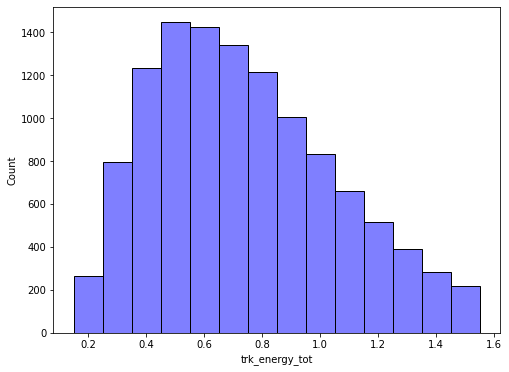

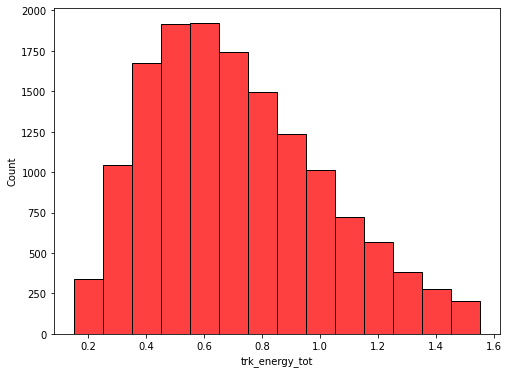

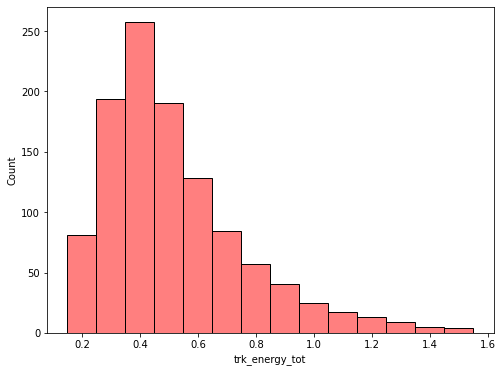

In [112]:
#this is with full run




#Get height of MC bins
MC_figure = plt.figure(figsize=(8,6))
bins=[0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55]
MC = sns.histplot(data=df_data, x='trk_energy_tot', bins=bins, color = 'blue', alpha = 0.5, weights = 1/6.29, multiple = "layer", palette = 'deep')
bins_array = np.array(bins)
bins_position = (bins_array[:-1] + bins_array[1:]) / 2
MC_bars = MC.patches
heights_MC = [patch.get_height() for patch in MC_bars]
y = heights_MC[:14]



#Get height of bins
Real_figure = plt.figure(figsize=(8,6))
Data = sns.histplot(data=df_data_real, x='trk_energy_tot', bins=bins, color= 'red', multiple = 'layer', palette = "Set1")
bars = Data.patches
heights = [patch.get_height() for patch in bars]
y_real = heights[:14]
y_real = np.array(y_real)
print(np.sum(y_real))

#Height of bin for EXT file
EXT_figure = plt.figure(figsize=(8,6))
EXT = sns.histplot(data=df_data_EXT, x='trk_energy_tot', bins=bins, color = 'red', alpha = 0.5, weights = 1/3.89, palette = 'deep')
bars = EXT.patches
heights_EXT = [patch.get_height() for patch in bars]
y_EXT = heights_EXT[:14]

MC_EXT_bins = np.add(heights_MC,heights_EXT)

np.sum(y_EXT)





In [107]:
def diseppearance(angle, E):
    #compute diseppearance fit for neutrinos
    # assume delta m = 1ev for now
    Prob = (np.sin(2*angle)**2)*(np.sin(1.27*500/E)**2)
    
    return Prob

def process_monte_carlo(bins_heights, angle, position_of_bins):
    probability = diseppearance(angle, position_of_bins)
    bins_heights_adjusted = (1-probability)*bins_heights
    
    return bins_heights_adjusted


def chi_distance(angle, real_heights, MC_heights, position_of_bins): # compute the chi-squared distance
    #probability
    probability = diseppearance(angle, position_of_bins)
    MC_heights_adjusted = (1-probability)*MC_heights
    
    chi = 0.5 * np.sum([((a - b) ** 2) / (a + b)
                      for (a, b) in zip(real_heights, MC_heights_adjusted)])
    return chi

test2 = chi_distance(1.4, heights, MC_EXT_bins, bins_position)
print(test2)
opt.minimize(chi_distance, 2, args=(heights,MC_EXT_bins,bins_position))

142.19913903938735


      fun: 77.36274055338563
 hess_inv: array([[0.00029473]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([1.57079632])

[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5]
14


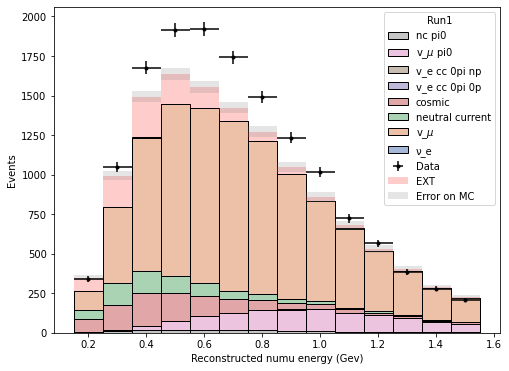

In [113]:
# Muon energy 


#energy_count  = df_data_real['trk_energy_muon_v'].value_counts()

# X values
x = np.arange(0.2, 1.6, 0.1)
# X values for EXT
x_EXT = np.arange(0.2, 1.6, 0.1)
#Y values for data points
print(x)

#Y error
y_error = np.sqrt(y_real)

#figure
plt.figure(figsize=(8,6))

test1 = sns.histplot(data=df_data, x='trk_energy_tot', hue = "category", bins=[0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55], color = 'blue', alpha = 0.5, weights = 1/6.29, multiple = "stack", palette = 'deep')





#MC error
MC_y_error = np.sqrt(y)
Bottom_MC = [a + b for a, b in zip(y, y_EXT)]

print(len(y_EXT))


#test2 = sns.histplot(data=df_data_real, x='trk_energy_muon_v', binwidth = 0.1, color = 'blue', alpha = 0.5)








#Error on data
plt.errorbar(x, y_real , yerr = y_error, xerr=0.05, fmt='.k');

#EXT added on top
plt.bar(x_EXT, y_EXT, width = 0.1, bottom = y, color='red', alpha=0.2)

#Error on MC
plt.bar(x, 2*MC_y_error, width = 0.1, bottom = Bottom_MC-MC_y_error, color='gray', alpha=0.2)



plt.legend(title='Run1', loc='upper right', labels =['nc pi0', 'v_'r'$\mu$'' pi0', 'v_e cc 0pi np', 'v_e cc 0pi 0p', 'cosmic', 'neutral current', 'v_'r'$\mu$', 'ν_e', 'Data', 'EXT', 'Error on MC'])

plt.xlabel("Reconstructed numu energy (Gev)")
plt.ylabel("Events")


plt.savefig('numu_energy.jpg', dpi=300)
plt.show()
